# Introduction to Neural Network (2)
### Week 2

[1] https://tutorials.pytorch.kr/beginner/basics/quickstart_tutorial.html \
[2] https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# 1. Classification - Fashion MNIST

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

### 1-1. Load Dataset 
Here’s an example of loading the Fashion-MNIST dataset from TorchVision. Fashion-MNIST is Zalando's article image dataset consisting of 60,000 training examples and 10,000 test examples. Each example is a 28x28 grayscale image paired with a label that corresponds to one of 10 classes.
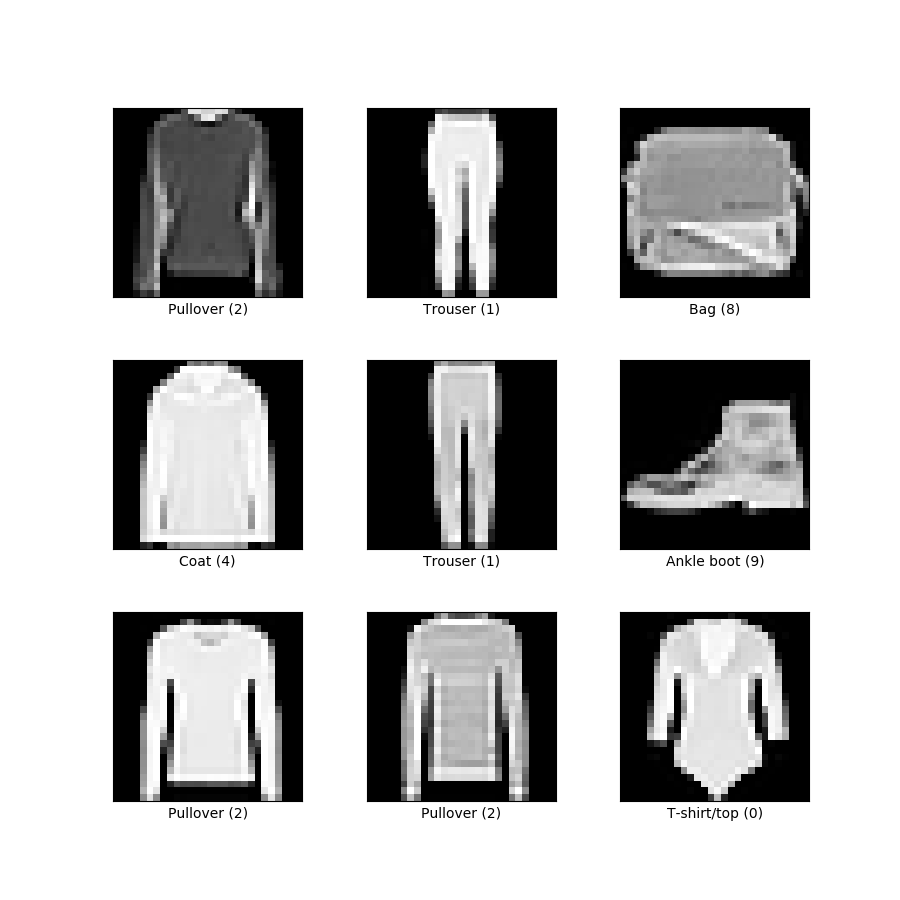

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",          # root specifies the path where the training/testing data is stored
    train=True,           # train indicates whether the dataset is for training or testing 
    download=True,        # download=True downloads the data from the internet if not present in root
    transform=ToTensor(), # transform and target_transform specify transformations for features and labels
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# Note: Labels for the FasionMNIST.
labels_map = {0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
              5: "Sandal",  6: "Shirt",   7: "Sneaker",  8: "Bag",   9: "Ankle Boot"}

In [3]:
batch_size = 64

# Create DataLoaders object.
# Note that the Dataset is provided as an argument to the DataLoader.
# This wraps the dataset into an iterable object, providing functionalities for batching, sampling, shuffling, and multiprocess data loading automatically.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Report
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


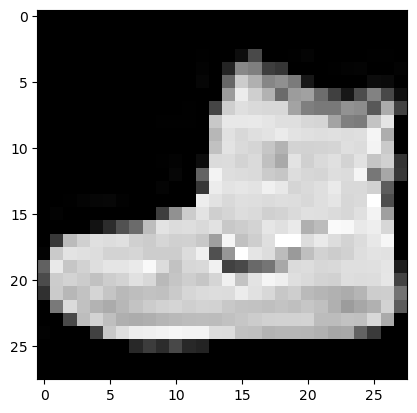

Label: 9


In [4]:
# Check data
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### 1-2. Define Model

In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" # Mac Silicon GPU (~1min)
    if torch.backends.mps.is_available()
    else "cpu" #(~30sec)
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10) # Output layer (10 classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)  # pass through NN
        return logits # Final Output return (10 classes)

model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### 1-3. Hyperparameters, Loss Function, and Optimizer

In [6]:
# Hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # lr = learning_rate

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Prediction and Loss
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # Training
        if batch % 100 == 0:
            loss, current = loss.item(), (batch +1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error (10,000 test data): \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### 1-4. Run Training

In [8]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.296909 [   64/60000]
loss: 2.296152 [ 6464/60000]
loss: 2.274738 [12864/60000]
loss: 2.264837 [19264/60000]
loss: 2.256200 [25664/60000]
loss: 2.205792 [32064/60000]
loss: 2.218572 [38464/60000]
loss: 2.176563 [44864/60000]
loss: 2.171364 [51264/60000]
loss: 2.130531 [57664/60000]
Test Error (10,000 test data): 
 Accuracy: 37.7%, Avg loss: 2.130928 

Epoch 2
-------------------------------
loss: 2.142238 [   64/60000]
loss: 2.132870 [ 6464/60000]
loss: 2.071501 [12864/60000]
loss: 2.081513 [19264/60000]
loss: 2.043416 [25664/60000]
loss: 1.967734 [32064/60000]
loss: 1.991277 [38464/60000]
loss: 1.907574 [44864/60000]
loss: 1.912524 [51264/60000]
loss: 1.831455 [57664/60000]
Test Error (10,000 test data): 
 Accuracy: 57.9%, Avg loss: 1.833868 

Epoch 3
-------------------------------
loss: 1.874407 [   64/60000]
loss: 1.838269 [ 6464/60000]
loss: 1.721020 [12864/60000]
loss: 1.755596 [19264/60000]
loss: 1.672226 [25664/60000]
loss: 1.61448

### 1-5. Save Model

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [10]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

### 1-6. Test Trained Model

In [11]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# 2. What is Convolution?

Text(0.5, 1.0, 'output(convoluted)')

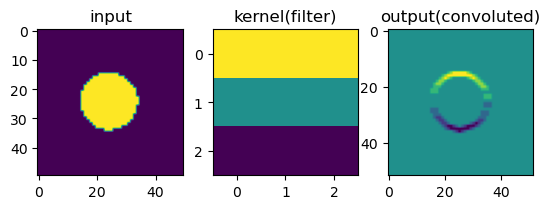

In [12]:
# How convolution result is showing
# Try to change the "kernel" and see what happens.

import scipy.signal
import numpy as np 
import matplotlib.pyplot as plt
  
x = np.linspace(1, 100)  
y = np.linspace(1, 100) 
# The meshgrid function returns 
# two 2-dimensional arrays    
x_1, y_1 = np.meshgrid(x, y) 
x_1_cen=x_1-50
y_1_cen=y_1-50
r=np.sqrt(x_1_cen**2+y_1_cen**2)

img=r<20

kernel=[[1, 1, 1], 
        [0, 0, 0],
        [-1,-1,-1]] # You can change this filter!

img_filtered=scipy.signal.convolve2d(img,kernel)

plt.subplot(131)
plt.imshow(img)
plt.title("input")
plt.subplot(132)
plt.imshow(kernel)
plt.title("kernel(filter)")
plt.subplot(133)
plt.imshow(img_filtered)
plt.title("output(convoluted)")

# 3. Classification via CNN

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 1. Load the Fashion-MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale images
])

# Training and test datasets
trainset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
testset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

# DataLoaders
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [14]:
# 2. Define the neural network (adjust for 1 channel input)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # Grayscale input: 1 channel, Colorscale input : 3 channel
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Adjust dimensions for Fashion-MNIST
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# 3. Define loss function and optimizer
learning_rate=0.001  # lr
momentum=0.9 # beta, 
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

##### * Note: Momentum is a technique that adjusts the current update by utilizing information from previous updates, reducing oscillations and accelerating convergence during the optimization process.

In [15]:
# 4. Train the network
for epoch in range(2):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # Print every 2000 mini-batches
            print(f"Training[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

print("Finished Training")

# 5. Test the network
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10,000 test images: {100 * correct / total}%")


Training[1, 2000] loss: 1.432
Training[1, 4000] loss: 0.673
Training[1, 6000] loss: 0.579
Training[1, 8000] loss: 0.534
Training[1, 10000] loss: 0.483
Training[1, 12000] loss: 0.448
Training[1, 14000] loss: 0.431
Training[2, 2000] loss: 0.401
Training[2, 4000] loss: 0.383
Training[2, 6000] loss: 0.378
Training[2, 8000] loss: 0.380
Training[2, 10000] loss: 0.359
Training[2, 12000] loss: 0.371
Training[2, 14000] loss: 0.345
Finished Training
Accuracy of the network on the 10,000 test images: 85.98%


#### Note that the Classification using CNN shows better accuracy on the test images!